## About WIS
Good ressources:
-  Supplement of Cramer et al.
- code cramer et al. here https://github.com/reichlab/covid19-forecast-evals
- obviously https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008618#sec015
- [git clone https://github.com/adrian-lison/interval-scoring.git](https://github.com/adrian-lison/interval-scoring/tree/master) Adrian Lison's code for WIS
- https://epiforecasts.io/scoringutils/ Scoring utils package -- perhaps best to use ?

In [1]:
from interval_scoring import scoring
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import myutils
import os

sns.set_theme()

In [2]:
# A modification of Lison's code that splits the calibration in underprediction and overprediction
def weighted_interval_score_fast(
    observations, alphas, q_dict, weights=None, percent=False, check_consistency=True
):
    """
    Compute weighted interval scores for an array of observations and a number of different predicted intervals.
    
    This function implements the WIS-score (2). A dictionary with the respective (alpha/2)
    and (1-(alpha/2)) quantiles for all alpha levels given in `alphas` needs to be specified.
    
    This is a more efficient implementation using array operations instead of repeated calls of `interval_score`.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    alphas : iterable
        Alpha levels for (1-alpha) intervals.
    q_dict : dict
        Dictionary with predicted quantiles for all instances in `observations`.
    weights : iterable, optional
        Corresponding weights for each interval. If `None`, `weights` is set to `alphas`, yielding the WIS^alpha-score.
    percent: bool, optional
        If `True`, score is scaled by absolute value of observations to yield a percentage error. Default is `False`.
    check_consistency: bool, optional
        If `True`, quantiles in `q_dict` are checked for consistency. Default is `True`.
        
    Returns
    -------
    total : array_like
        Total weighted interval scores.
    sharpness : array_like
        Sharpness component of weighted interval scores.
    calibration : array_like
        Calibration component of weighted interval scores.
        
    (2) Bracher, J., Ray, E. L., Gneiting, T., & Reich, N. G. (2020). Evaluating epidemic forecasts in an interval format. arXiv preprint arXiv:2005.12881.
    """
    if weights is None:
        weights = np.array(alphas)/2

    if not all(alphas[i] <= alphas[i + 1] for i in range(len(alphas) - 1)):
        raise ValueError("Alpha values must be sorted in ascending order.")

    reversed_weights = list(reversed(weights))

    lower_quantiles = [q_dict.get(alpha / 2) for alpha in alphas]
    upper_quantiles = [q_dict.get(1 - (alpha / 2)) for alpha in reversed(alphas)]
    if any(q is None for q in lower_quantiles) or any(
        q is None for q in upper_quantiles
    ):
        raise ValueError(
            f"Quantile dictionary does not include all necessary quantiles."
        )

    lower_quantiles = np.vstack(lower_quantiles)
    upper_quantiles = np.vstack(upper_quantiles)

    # Check for consistency
    if check_consistency and np.any(
        np.diff(np.vstack((lower_quantiles, upper_quantiles)), axis=0) < 0
    ):
        raise ValueError("Quantiles are not consistent.")

    lower_q_alphas = (2 / np.array(alphas)).reshape((-1, 1))
    upper_q_alphas = (2 / np.array(list(reversed(alphas)))).reshape((-1, 1))

    # compute score components for all intervals
    sharpnesses = np.flip(upper_quantiles, axis=0) - lower_quantiles

    lower_calibrations = (
        np.clip(lower_quantiles - observations, a_min=0, a_max=None) * lower_q_alphas
    )
    upper_calibrations = (
        np.clip(observations - upper_quantiles, a_min=0, a_max=None) * upper_q_alphas
    )
    calibrations = lower_calibrations + np.flip(upper_calibrations, axis=0)
    upper_calibrations = np.flip(upper_calibrations, axis=0)
    lower_calibrations = lower_calibrations

    # scale to percentage absolute error
    if percent:
        sharpnesses = sharpnesses / np.abs(observations)
        calibrations = calibrations / np.abs(observations)
        raise ValueError("Not Supported with the calibration split")

    totals = sharpnesses + calibrations

    # weigh scores
    weights = np.array(weights).reshape((-1, 1))

    sharpnesses_weighted = sharpnesses * weights
    calibrations_weighted = calibrations * weights
    upper_calibrations_weighted = upper_calibrations * weights
    lower_calibrations_weighted = lower_calibrations * weights
    totals_weighted = totals * weights

    # normalize and aggregate all interval scores
    weights_sum = np.sum(weights)

    sharpnesses_final = np.sum(sharpnesses_weighted, axis=0) / weights_sum
    calibrations_final = np.sum(calibrations_weighted, axis=0) / weights_sum
    upper_calibrations_final = np.sum(upper_calibrations_weighted, axis=0) / weights_sum
    lower_calibrations_final = np.sum(lower_calibrations_weighted, axis=0) / weights_sum
    totals_final = np.sum(totals_weighted, axis=0) / weights_sum

    return totals_final, sharpnesses_final, calibrations_final, lower_calibrations_final, upper_calibrations_final

In [3]:
image_size = 64
channels = 1
batch_size=512
season_first_year="2022"
import nn_blocks, idplots, ddpm, myutils, inpaint, ground_truth
gt1 = ground_truth.GroundTruth(season_first_year=season_first_year, 
                                data_date=datetime.datetime(2023,7,25), 
                                mask_date=datetime.datetime(2023,7,25),
                                channels=channels,
                                image_size=image_size,
                                nogit=True #so git is not damaged.
                            )

Spatial Setup with 51 locations.
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Masking, >> 52 weeks already in data, inpainting the next ones


In [4]:
def score_Nwk_forecasts(gt, forecasts, n=4) -> pd.DataFrame: 
    if isinstance(gt, str):
        gt = pd.read_csv(gt)
    if isinstance(forecasts, str):
        forecast = pd.read_csv(forecasts)

    # take only the locations and dates that are forecasted
    gt = gt[gt["location"].isin(forecasts["location"])]
    gt = gt[gt["date"].isin(forecasts.target_end_date)]

    #first_forecast_date = datetime.datetime.strptime(forecasts["target_end_date"].sort_values()[0], "%Y-%m-%d").date()
    #target_dates = pd.date_range(first_forecast_date, first_forecast_date + datetime.timedelta(days=n*7), freq="W-SAT").date

    gt_piv = gt.pivot(index="date", columns="location", values="value").sort_index()


    target_dict = dict(zip(gt_piv.index, [f"{n} wk ahead" for n in range(1,n+1)]))
    
    # Alpha for WIS
    alphas=np.array(sorted(forecasts["quantile"].unique()))[:11]*2
    
    # gt_piv.index should be similar to target_dict.keys() apart from format

    all_targets = []
    
    for target in target_dict.keys():
        f = forecasts[forecasts["target_end_date"] == target]
        q_dict = {}
        for q in f["quantile"].unique():
            q_dict[float(q)] = f[f["quantile"]==q].pivot(index=["target_end_date"], columns="location", values="value").sort_index().to_numpy().ravel()
        wis_total, wis_sharpness, wis_calibration, overprediction, underprediction =   weighted_interval_score_fast(observations=gt_piv.loc[target].to_numpy(), 
                                                                                        alphas=alphas, 
                                                                                        q_dict=q_dict, 
                                                                                        weights=alphas/2)
        df = pd.DataFrame([wis_total, wis_sharpness, wis_calibration, underprediction, overprediction], index = ["wis_total", "wis_sharpness", "wis_calibration", "wis_underprediction", "wis_overprediction"], columns=gt_piv.columns)
        df["target"] = target_dict[target]
        df["target_end_date"] = target    
        all_targets.append(df)

    
    return pd.concat(all_targets).reset_index(names="wis_type").set_index(["target", "target_end_date"])

In [5]:
path_flusight = "Flusight/Flusight-forecast-data/data-forecasts/"
flusight_model_list = myutils.get_folders_in_directory(path_flusight)
ignored = [ "LosAlamos_NAU-CModel_Flu","SigSci-CREG","SigSci-TSENS","LUcompUncertLab-experthuman", "VTSanghani-ExogModel","CADPH-FluCAT_Ensemble"]
for element in ignored :
    flusight_model_list.remove(element)

#flusight_model_list = ["UNC_IDD-InfluPaint"]

hostname = os.uname().nodename

if "blinky" in hostname.lower():
    path_myforecasts = "forecasts/"
    path_myforecasts_noTT = "forecasts_noTT/"
else:
    path_myforecasts = "/work/users/c/h/chadi/influpaint_res/3d47f4a_2023-11-07/forecasts/"

my_model_list = myutils.get_folders_in_directory(path_myforecasts)
my_model_list_noTT = myutils.get_folders_in_directory(path_myforecasts_noTT)

In [6]:
model_files = {
    path_flusight:flusight_model_list,
    #path_flusight:["Flusight-baseline"],
    #path_myforecasts:my_model_list,
    path_myforecasts_noTT:my_model_list_noTT
}

In [7]:
#gt1.plot()

In [7]:
fdates = pd.date_range("2022-10-12", "2023-05-15", freq="1W-MON")

#fdates = pd.date_range("2022-10-12", "2023-03-15", freq="5W-MON") #old

fdates = pd.DatetimeIndex(['2022-11-07','2022-11-14','2022-12-12','2023-01-09','2023-03-06']) #new
#fdates = pd.DatetimeIndex(['2022-11-07'])#'2023-01-09','2023-03-06']) #new

#fdates = pd.date_range("2022-11-14", "2023-05-15", freq="5W-MON") # old

fdates = pd.date_range("2022-10-12", "2023-05-15", freq="2W-MON") #noTT
fdates = pd.date_range("2022-10-12", "2023-04-30", freq="2W-MON") #noTT

gt = pd.read_csv("Flusight/Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv")


allow_missing_week = 5
scores = {}
forecasts_d = {}

for path, model_list in model_files.items():
    for model in model_list:
        print(model, end=' ')
        skipped = []
        scores[model] = {}
        forecasts_d[model] = {}
        for date in fdates:
            date = date.date()
            try:
                if "Flusight" in path:
                    for_df = pd.read_csv(f"{path}{model}/{str(date)}-{model}.csv")
                else:
                    for_df = pd.read_csv(f"{path}{model}/{model}-{str(date)}.csv")
                for_df = for_df[for_df["type"]=="quantile"]
                this_date=True
                #print("read ✔️", end=' ')
            except FileNotFoundError:
                skipped.append(date)
                this_date=False
                #print("read ❌", end=' ')
            if this_date:
                wis_all = score_Nwk_forecasts(gt, for_df)
                scores[model][date] = wis_all
                forecasts_d[model][date] = for_df
        if len(skipped) < allow_missing_week+1:
            print("added ✅", end=' ')
            if len(skipped): print(f">> ‼️ skipped {','.join([str(i) for i in skipped])}", end=' ')
            scores[model + f"!{len(skipped)}!"] = pd.concat(scores[model], names=["forecast_date", "target", "target_end_date"])
            forecasts_d[model + f"!{len(skipped)}!"] = pd.concat(forecasts_d[model], names=["forecast_date"])
            scores.pop(model)
            forecasts_d.pop(model)
        else:
            scores.pop(model)
            forecasts_d.pop(model)
            print("discarded ❌", end=' ')
        print()


all_scores = pd.concat(scores, names=["model", "forecast_date", "target", "target_end_date"])
all_forecasts = pd.concat(forecasts_d, names=["model"]).reset_index(level='model').reset_index(drop=True)
wis_total = all_scores[all_scores["wis_type"] == "wis_total"].drop("wis_type", axis=1)
wis_total  = pd.melt(wis_total , var_name="location", value_name="wis_total",ignore_index=False).reset_index()

wis_underprediction = all_scores[all_scores["wis_type"] == "wis_underprediction"].drop("wis_type", axis=1)
wis_underprediction = pd.melt(wis_underprediction , var_name="location", value_name="wis_underprediction",ignore_index=False).reset_index()

wis_overprediction = all_scores[all_scores["wis_type"] == "wis_overprediction"].drop("wis_type", axis=1)
wis_overprediction = pd.melt(wis_overprediction , var_name="location", value_name="wis_overprediction",ignore_index=False).reset_index()

wis_sharpness = all_scores[all_scores["wis_type"] == "wis_sharpness"].drop("wis_type", axis=1)
wis_sharpness = pd.melt(wis_sharpness , var_name="location", value_name="wis_sharpness",ignore_index=False).reset_index()

all_scores_t = all_scores.reset_index()

id_vars = ['model', 'forecast_date', 'target', 'target_end_date', 'wis_type']

# Identify two-letter columns dynamically
location_columns = [col for col in all_scores_t.columns if len(col) == 2]

# Melt the DataFrame to move two-letter columns into a 'location' column
all_scores_t = pd.melt(all_scores_t, id_vars=id_vars, value_vars=location_columns, var_name='location', value_name='value')
all_scores_t

VTSanghani-Transformer discarded ❌ 
Flusight-baseline added ✅ 
ISU_NiemiLab-Flu added ✅ >> ‼️ skipped 2022-10-17,2022-10-31,2023-04-03,2023-04-17 
MIGHTE-Nsemble added ✅ >> ‼️ skipped 2022-10-17 
LUcompUncertLab-VAR2K_plusCOVID discarded ❌ 
CU-ensemble added ✅ >> ‼️ skipped 2022-12-26,2023-01-23,2023-04-03 
JHUAPL-Gecko discarded ❌ 
SGroup-RandomForest added ✅ >> ‼️ skipped 2022-12-26 
LUcompUncertLab-hier_mech_model discarded ❌ 
UMass-trends_ensemble added ✅ 
CMU-TimeSeries added ✅ 
UNC_IDD-InfluPaint added ✅ >> ‼️ skipped 2022-10-17,2022-10-31,2022-11-28 
LUcompUncertLab-KalmanFilter discarded ❌ 
SGroup-SIkJalpha discarded ❌ 
Umass-ARIMA discarded ❌ 
CEID-Walk discarded ❌ 
LUcompUncertLab-humanjudgment discarded ❌ 
Flusight-ensemble added ✅ 
PSI-DICE added ✅ 
IEM_Health-FluProject discarded ❌ 
UT_FluCast-Voltaire discarded ❌ 
JHU_IDD-CovidSP added ✅ >> ‼️ skipped 2022-10-17,2022-12-12,2022-12-26,2023-04-03 
LUcompUncertLab-VAR2_plusCOVID discarded ❌ 
LUcompUncertLab-ensemble_rclp dis

model forecast_date  \
0                                     Flusight-baseline!0!    2022-10-17   
1                                     Flusight-baseline!0!    2022-10-17   
2                                     Flusight-baseline!0!    2022-10-17   
3                                     Flusight-baseline!0!    2022-10-17   
4                                     Flusight-baseline!0!    2022-10-17   
...                                                    ...           ...   
1141555  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1141556  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1141557  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1141558  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1141559  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   

             target target_end_date             wis_type location        value  
0        1 wk ahead      2022-10-22            wis_total       01   189.382932  
1        1 wk ahead      2022-10-22        wis_sharpness       01    12.140044  
2        1 wk ahead      2022-10-22      wis_calibration       01   177.242888  
3        1 wk ahead      2022-10-22  wis_underprediction       01   177.242888  
4        1 wk ahead      2022-10-22   wis_overprediction       01     0.000000  
...             ...             ...                  ...      ...          ...  
1141555  4 wk ahead      2023-05-13            wis_total       US  2888.006972  
1141556  4 wk ahead      2023-05-13        wis_sharpness       US    92.523035  
1141557  4 wk ahead      2023-05-13      wis_calibration       US  2795.483937  
1141558  4 wk ahead      2023-05-13  wis_underprediction       US  2795.483937  
1141559  4 wk ahead      2023-05-13   wis_overprediction       US     0.000000  

[1141560 rows x 7 columns]

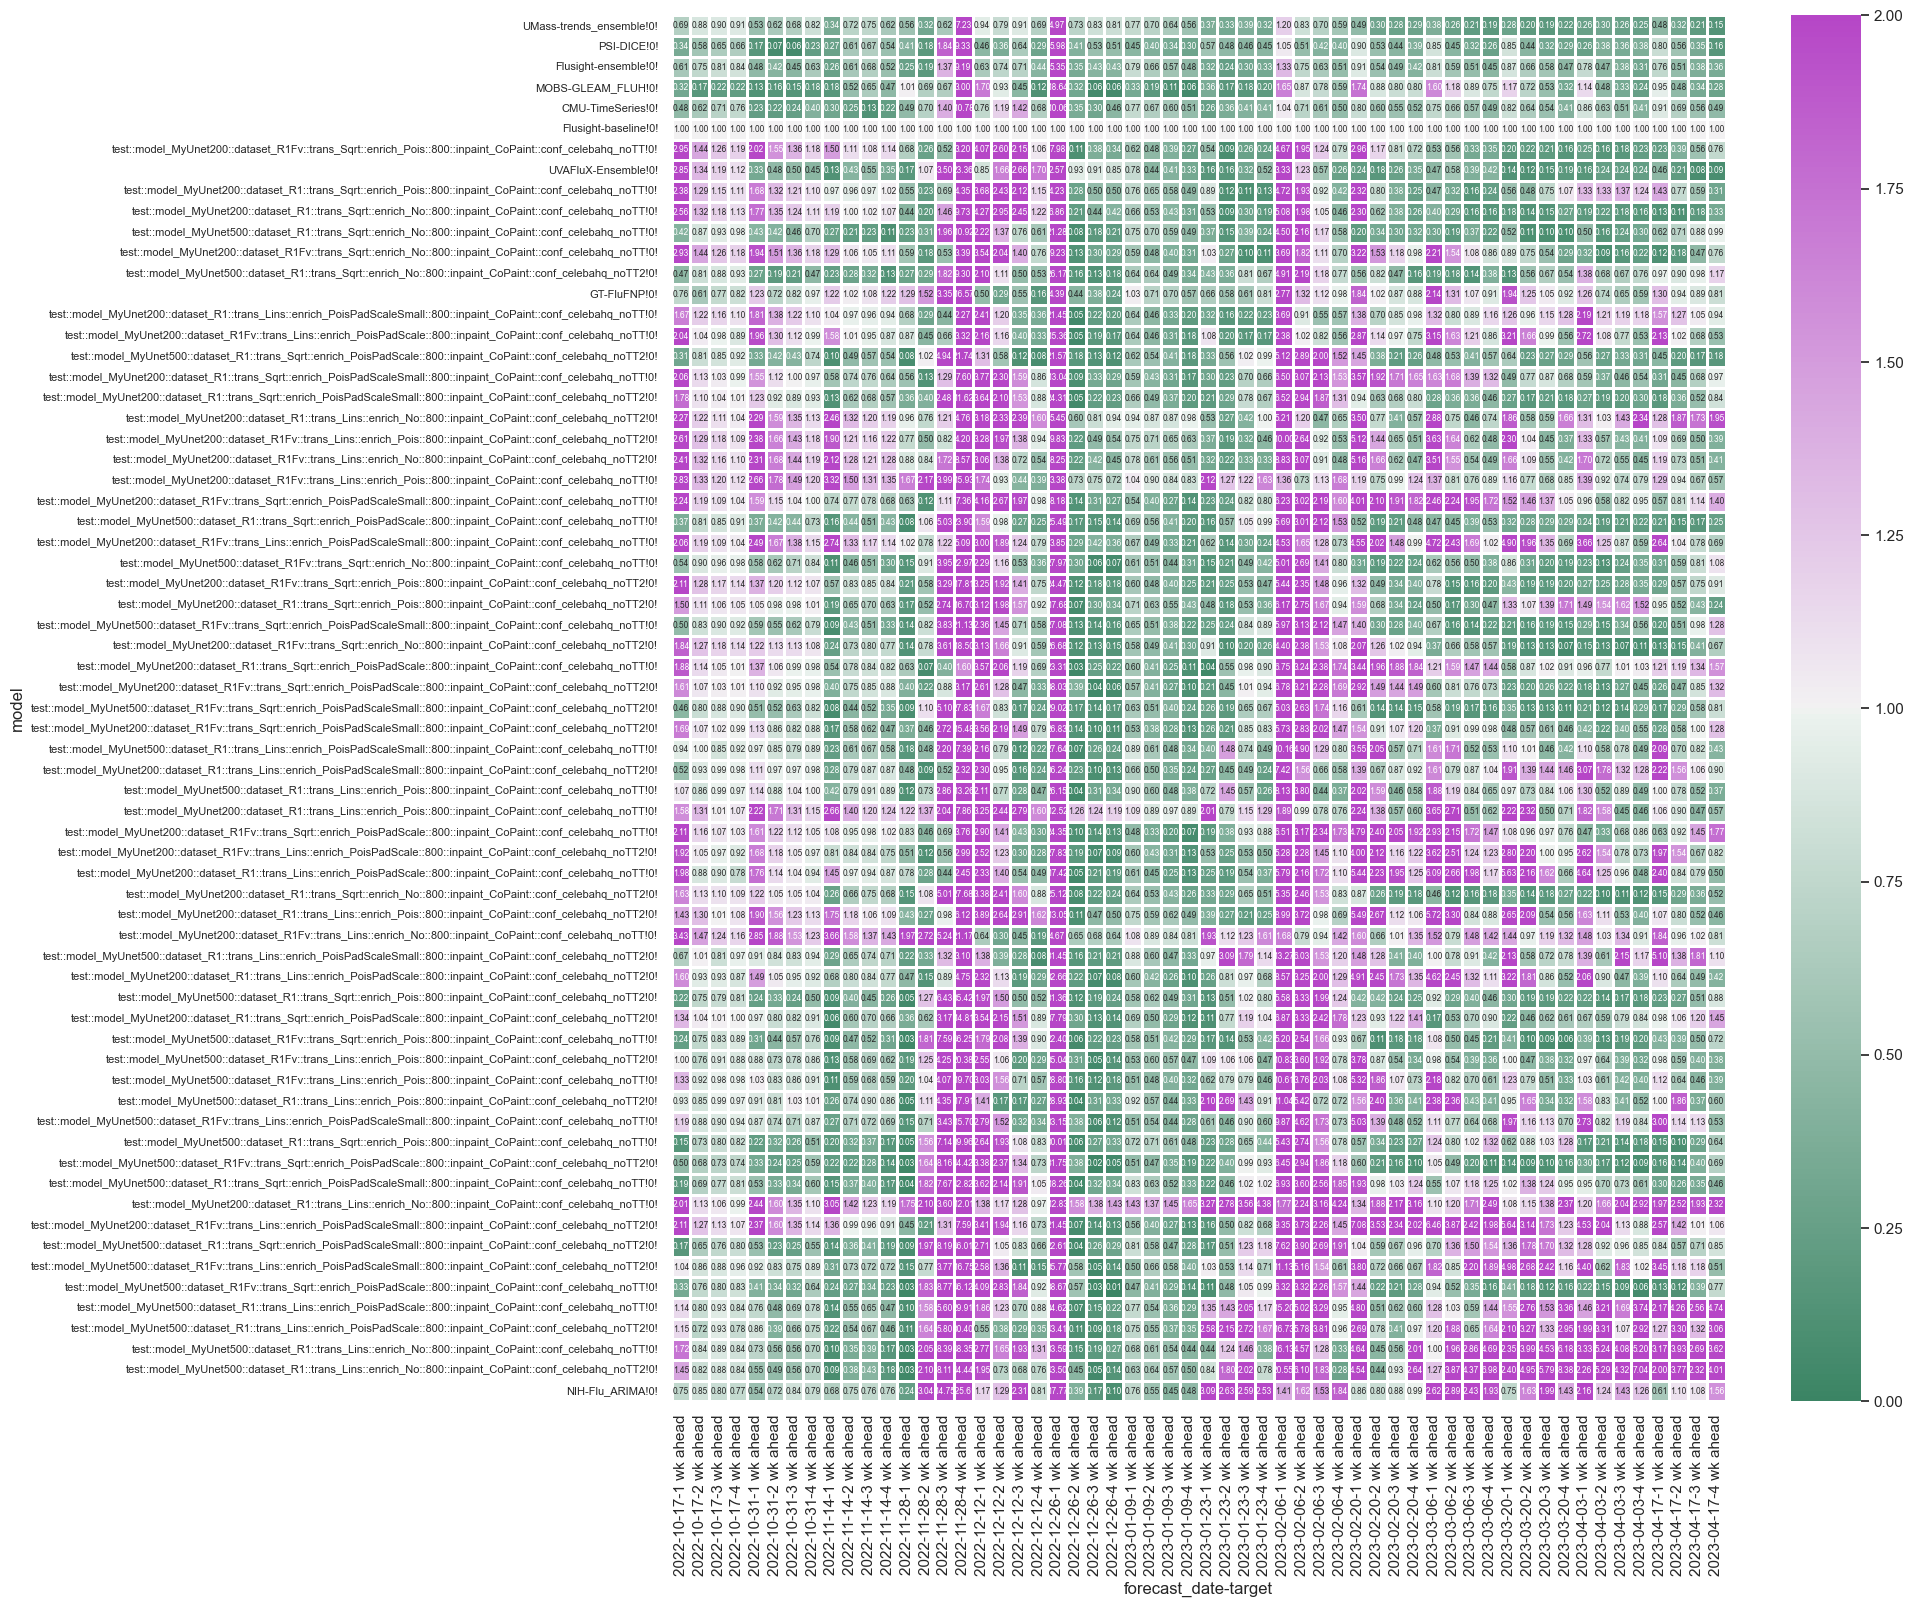

In [9]:
baseline_model = "Flusight-baseline!0!"
baseline = all_scores_t[all_scores_t["model"] == baseline_model]

all_scores_rel = all_scores_t[all_scores_t["wis_type"] == "wis_total"].copy()
all_scores_rel = pd.merge(all_scores_rel, baseline, on=['forecast_date', 'target', 'target_end_date', 'wis_type', 'location'], suffixes=('', '_baseline'))
all_scores_rel['value'] /= all_scores_rel['value_baseline']
all_scores_rel = all_scores_rel.drop(["value_baseline", "model_baseline"], axis=1)
all_scores_rel

rel_df = all_scores_rel.pivot_table(index=['model'],
                                                columns=['wis_type'], #
                                                values='value',
                                                aggfunc='mean').reset_index()

tp2 = all_scores_rel[(all_scores_rel["location"]=="US")].pivot_table(index=['model'], 
                    columns=['forecast_date', 'target'], 
                    values='value', aggfunc='mean')

s = tp2.sum(axis=1)
#s = tp2[[datetime.date(2022,11,7),datetime.date(2022,11,14)]].sum(axis=1) # odered by how they perform on the first
#s = tp2[[datetime.date(2022,11,7),datetime.date(2022,11,14),datetime.date(2022,12,12)]].sum(axis=1)
tp2 = tp2.loc[s.sort_values().index]

if False:
    tp2 = tp2.loc[:"Flusight-baseline!0!"]

f, ax = plt.subplots(figsize=(17, 18))
cmap = sns.diverging_palette(150, 300, as_cmap=True, center='light')
heatmap = sns.heatmap(tp2, annot=True, fmt=".2f", linewidths=1, ax=ax, center=1, cmap=cmap, vmin=0, vmax=2, annot_kws={"fontsize": 6})

#threshold = 1
#mask = np.abs(tp2) > threshold
#heatmap = sns.heatmap(tp2, annot=False, fmt="", linewidths=1, ax=ax, center=0, cmap='reds', mask=mask, cbar=False)
heatmap.set_yticks(np.arange(len(tp2.index)) + 0.5, minor=False)
heatmap.set_yticklabels(tp2.index, size=8)
plt.show()

/Users/chadi/anaconda3/envs/diffusion_torch/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from current font.
  func(*args, **kwargs)
/Users/chadi/anaconda3/envs/diffusion_torch/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


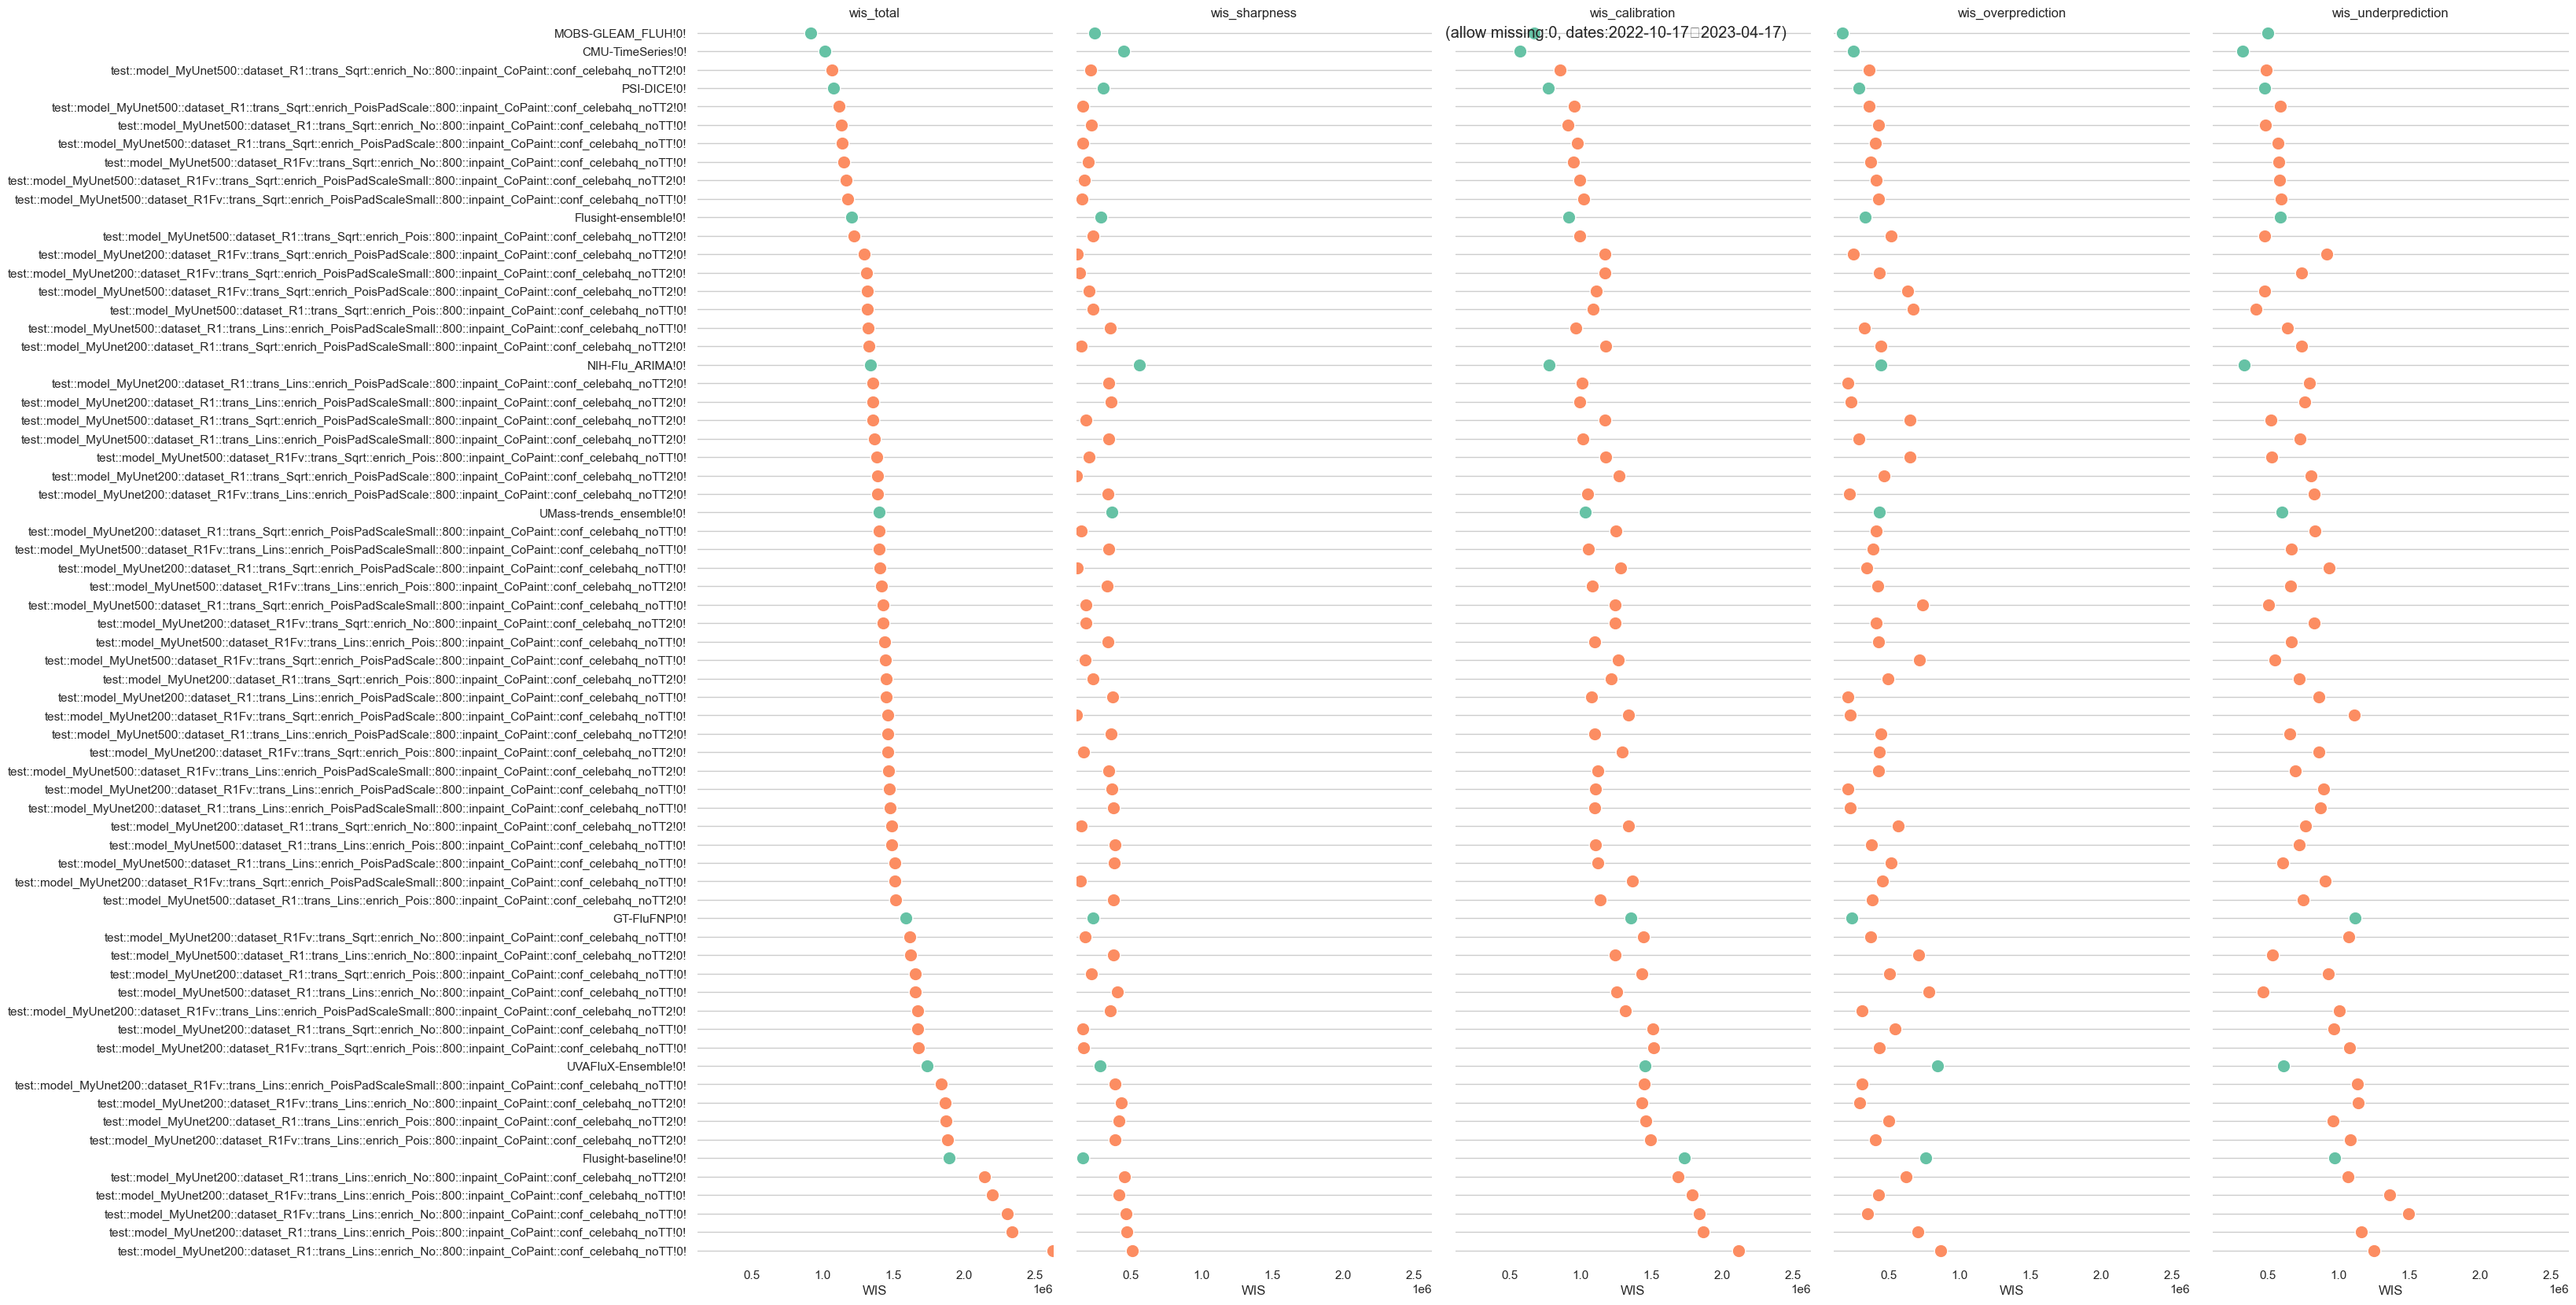

In [20]:
all_loc_df = all_scores_t.pivot_table(index=['model'],
                                                columns=['wis_type'], #
                                                values='value',
                                                aggfunc='sum').reset_index()

us_df = all_scores_t[all_scores_t['location'] == 'US'].pivot_table(index=['model'],
                                                columns=['wis_type'],
                                                values='value',
                                                aggfunc='sum').reset_index()



sns.set_theme(style="whitegrid")

to_plot = all_loc_df
#to_plot = us_df
to_plot['color'] = 0.0  # Default color

# Set the color to 'red' for models with '::' in their names
to_plot.loc[to_plot['model'].str.contains('::'), 'color'] = 3
to_plot.loc[to_plot['model'].str.contains('CoPaint'), 'color'] = 2

to_plot = to_plot.sort_values("wis_total").reset_index()

if False:
    to_plot = to_plot.iloc[:int(to_plot[to_plot["model"]=="JHU_IDD-CovidSP"].index[0])+1]


# Make the PairGrid
g = sns.PairGrid(to_plot,
                    x_vars=[ 'wis_total', 'wis_sharpness', 'wis_calibration',  'wis_overprediction', 'wis_underprediction'], y_vars=["model"], # to_plot.columns[-5:]
                    hue='color',palette="Set2", 
                    height=len(to_plot)/4, aspect=.3, )

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=12, orient="h", jitter=False, #color=to_plot['color'],
    linewidth=1, edgecolor="w")

min_x = to_plot[['wis_total', 'wis_sharpness', 'wis_calibration', 'wis_overprediction', 'wis_underprediction']].min().min()
max_x = to_plot[['wis_total', 'wis_sharpness', 'wis_calibration', 'wis_overprediction', 'wis_underprediction']].max().max()
g.set(xlim=(min_x, max_x))

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="WIS", ylabel="")#xlim=(to_plot[to_plot.columns[-5:]].max().max()), 

# Use semantically meaningful titles for the columns
titles = [ 'wis_total', 'wis_sharpness', 'wis_calibration',  'wis_overprediction', 'wis_underprediction']

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.figure.suptitle(f"(allow missing:{allow_missing_week}, dates:{fdates[0].date()}➡{fdates[-1].date()})")
sns.despine(left=True, bottom=True)

In [11]:
all_scores_t

model forecast_date  \
0                                     Flusight-baseline!0!    2022-10-17   
1                                     Flusight-baseline!0!    2022-10-17   
2                                     Flusight-baseline!0!    2022-10-17   
3                                     Flusight-baseline!0!    2022-10-17   
4                                     Flusight-baseline!0!    2022-10-17   
...                                                    ...           ...   
1013035  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1013036  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1013037  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1013038  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
1013039  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   

             target target_end_date             wis_type location        value  
0        1 wk ahead      2022-10-22            wis_total       01   189.382932  
1        1 wk ahead      2022-10-22        wis_sharpness       01    12.140044  
2        1 wk ahead      2022-10-22      wis_calibration       01   177.242888  
3        1 wk ahead      2022-10-22  wis_underprediction       01   177.242888  
4        1 wk ahead      2022-10-22   wis_overprediction       01     0.000000  
...             ...             ...                  ...      ...          ...  
1013035  4 wk ahead      2023-05-13            wis_total       US  2888.006972  
1013036  4 wk ahead      2023-05-13        wis_sharpness       US    92.523035  
1013037  4 wk ahead      2023-05-13      wis_calibration       US  2795.483937  
1013038  4 wk ahead      2023-05-13  wis_underprediction       US  2795.483937  
1013039  4 wk ahead      2023-05-13   wis_overprediction       US     0.000000  

[1013040 rows x 7 columns]

<Axes: xlabel='model'>

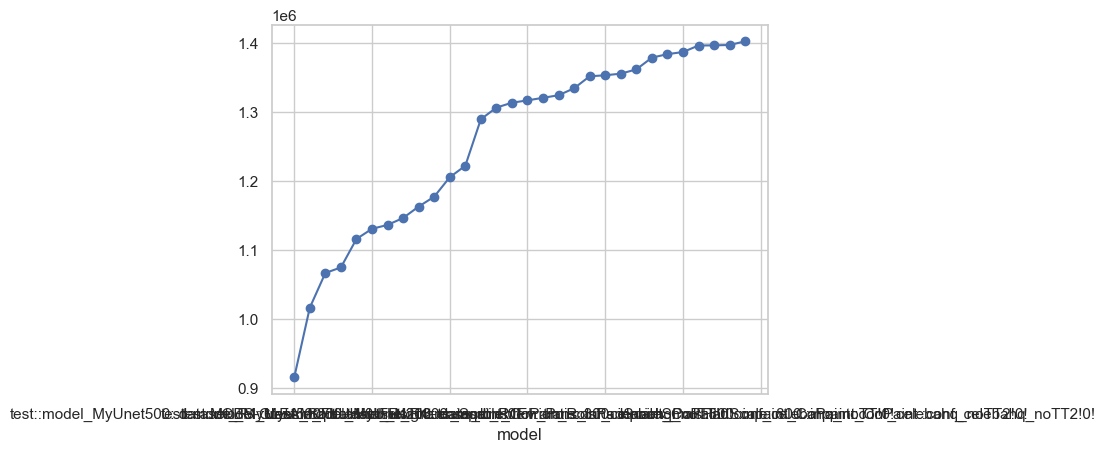

In [19]:
tp2.sum(axis=1).iloc[0:30].plot(marker='o')

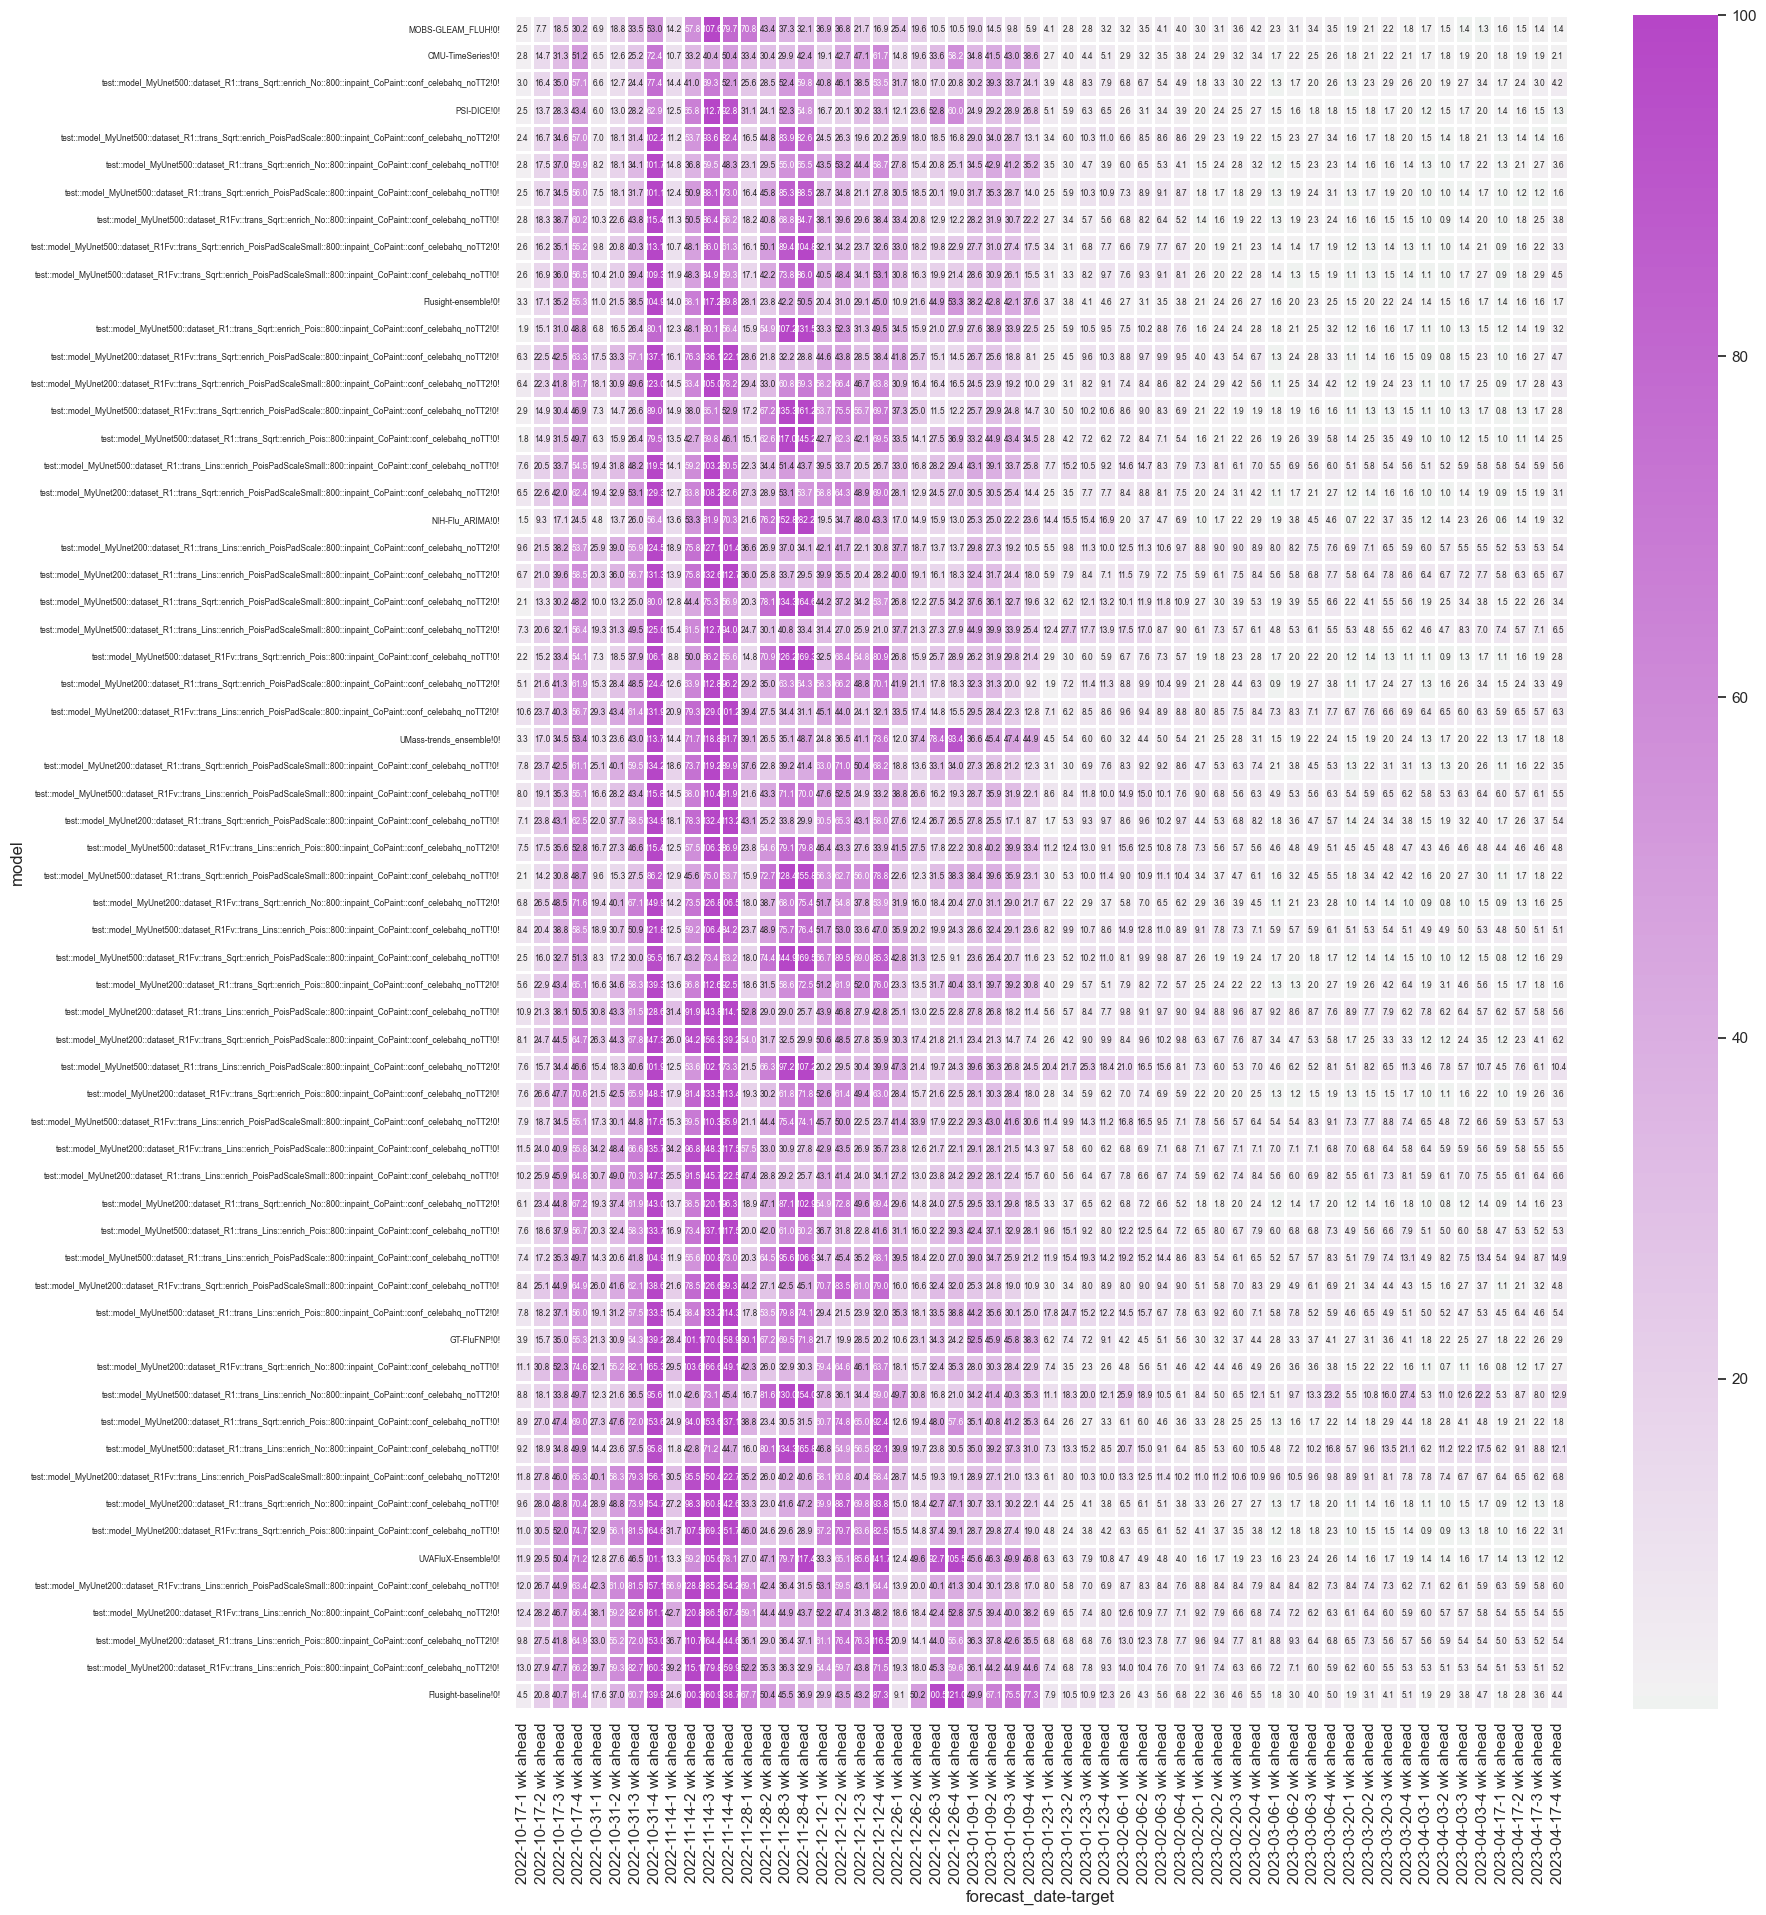

In [18]:
%matplotlib inline
tp2 = all_scores_t[(all_scores_t["wis_type"]=="wis_total")].pivot_table(index=['model'], 
                    columns=['forecast_date', 'target'],
                    values='value', aggfunc='sum')

s = tp2.sum(axis=1)
#s = tp2[[datetime.date(2022,11,7)]].sum(axis=1) # odered by how they perform on the first
#s = tp2[[datetime.date(2022,11,7),datetime.date(2022,11,14),datetime.date(2022,12,12)]].sum(axis=1)
tp2 = tp2.loc[s.sort_values().index]

if True:
    tp2 = tp2.loc[:"Flusight-baseline!0!"]

f, ax = plt.subplots(figsize=(17, 22))
cmap = sns.diverging_palette(150, 300, as_cmap=True, center='light')
heatmap = sns.heatmap(tp2/1000, annot=True, fmt=".1f", linewidths=1, ax=ax, center=1,vmax=100, cmap=cmap,  annot_kws={"fontsize": 6})#,

#threshold = 1
#mask = np.abs(tp2) > threshold
#heatmap = sns.heatmap(tp2, annot=False, fmt="", linewidths=1, ax=ax, center=0, cmap='reds', mask=mask, cbar=False)
heatmap.set_yticks(np.arange(len(tp2.index)) + 0.5, minor=False)
heatmap.set_yticklabels(tp2.index, size=6)
plt.show()

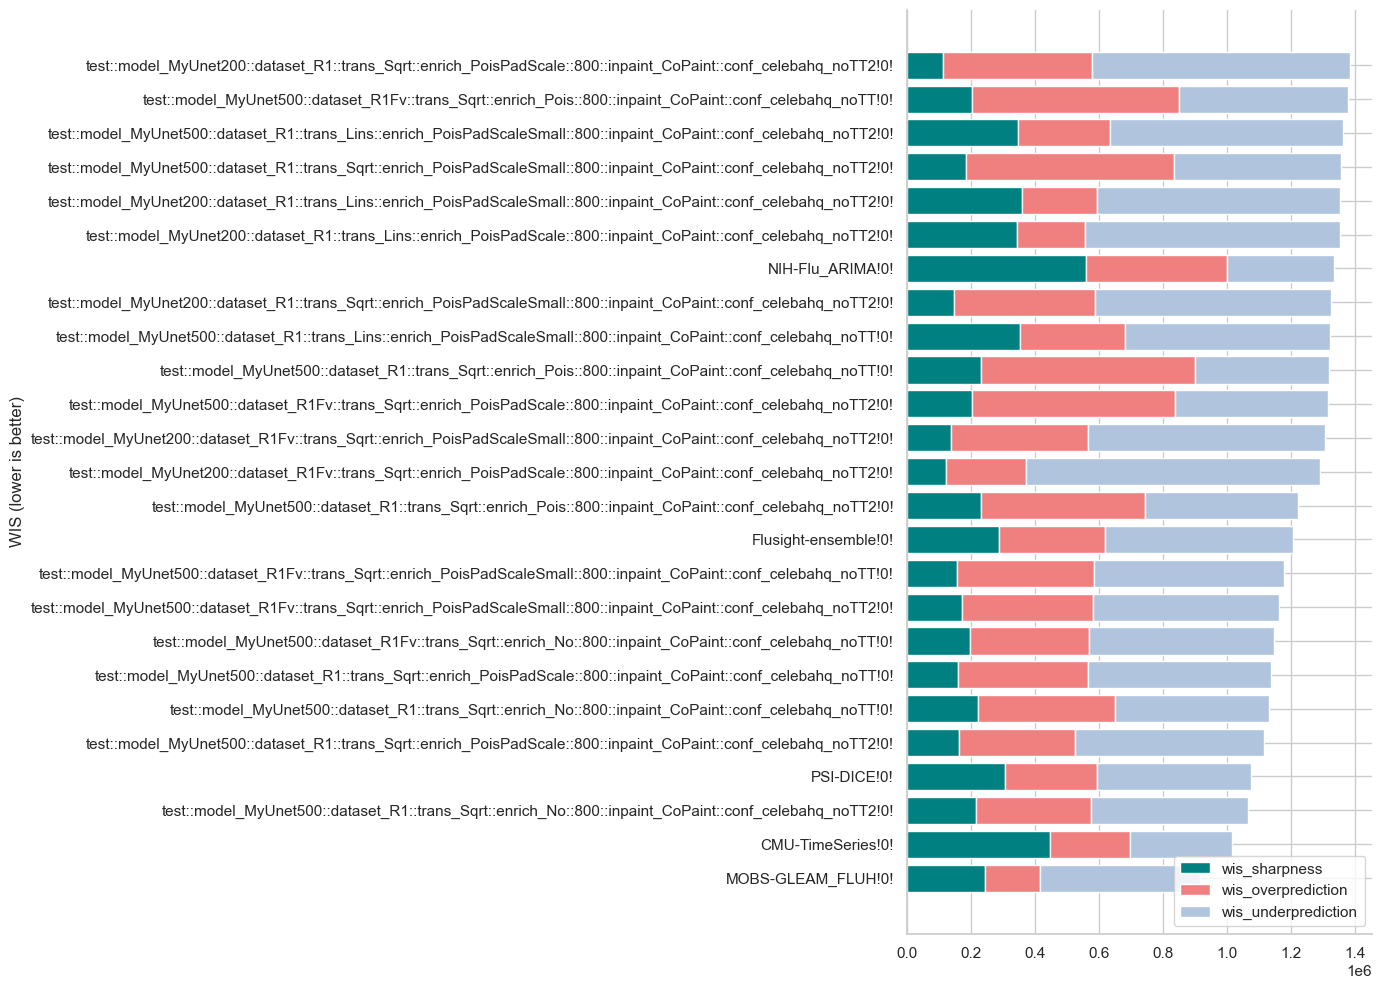

In [14]:
colors = ['teal', 'lightcoral', 'lightsteelblue']
fig, ax = plt.subplots(1,1, figsize=(6,12))


tp = to_plot.drop(['wis_calibration', 'wis_total', 'color','index'], axis=1).set_index('model',drop=True)[['wis_sharpness','wis_overprediction','wis_underprediction']].iloc[0:25]
#ax.bar(tp.index, tp, stacked=True, color=colors)

bottom = np.zeros(len(tp))
for color_idx, colname in enumerate(tp.columns):
    p = ax.barh(tp.index, tp[colname], color=colors[color_idx], left=bottom, label = colname)
    bottom += tp[colname]
plt.gca().set_ylabel("WIS (lower is better)")
ax.legend()
sns.despine(ax=plt.gca())

In [15]:
all_forecasts

model forecast_date  \
0                                     Flusight-baseline!0!    2022-10-17   
1                                     Flusight-baseline!0!    2022-10-17   
2                                     Flusight-baseline!0!    2022-10-17   
3                                     Flusight-baseline!0!    2022-10-17   
4                                     Flusight-baseline!0!    2022-10-17   
...                                                    ...           ...   
4435223  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
4435224  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
4435225  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
4435226  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   
4435227  test::model_MyUnet200::dataset_R1::trans_Sqrt:...    2023-04-17   

                          target target_end_date location      type  quantile  \
0        1 wk ahead inc flu hosp      2022-10-22       US  quantile     0.010   
1        1 wk ahead inc flu hosp      2022-10-22       US  quantile     0.025   
2        1 wk ahead inc flu hosp      2022-10-22       US  quantile     0.050   
3        1 wk ahead inc flu hosp      2022-10-22       US  quantile     0.100   
4        1 wk ahead inc flu hosp      2022-10-22       US  quantile     0.150   
...                          ...             ...      ...       ...       ...   
4435223  4 wk ahead inc flu hosp      2023-05-13       56  quantile     0.990   
4435224  1 wk ahead inc flu hosp      2023-04-22       US  quantile     0.990   
4435225  2 wk ahead inc flu hosp      2023-04-29       US  quantile     0.990   
4435226  3 wk ahead inc flu hosp      2023-05-06       US  quantile     0.990   
4435227  4 wk ahead inc flu hosp      2023-05-13       US  quantile     0.990   

               value  
0         943.000000  
1        1114.000000  
2        1211.000000  
3        1329.000000  
4        1412.000000  
...              ...  
4435223     5.826504  
4435224   985.008273  
4435225   847.072722  
4435226   757.891267  
4435227   633.424846  

[4435228 rows x 8 columns]

0 2022-10-17
1 2022-10-31


KeyboardInterrupt: 

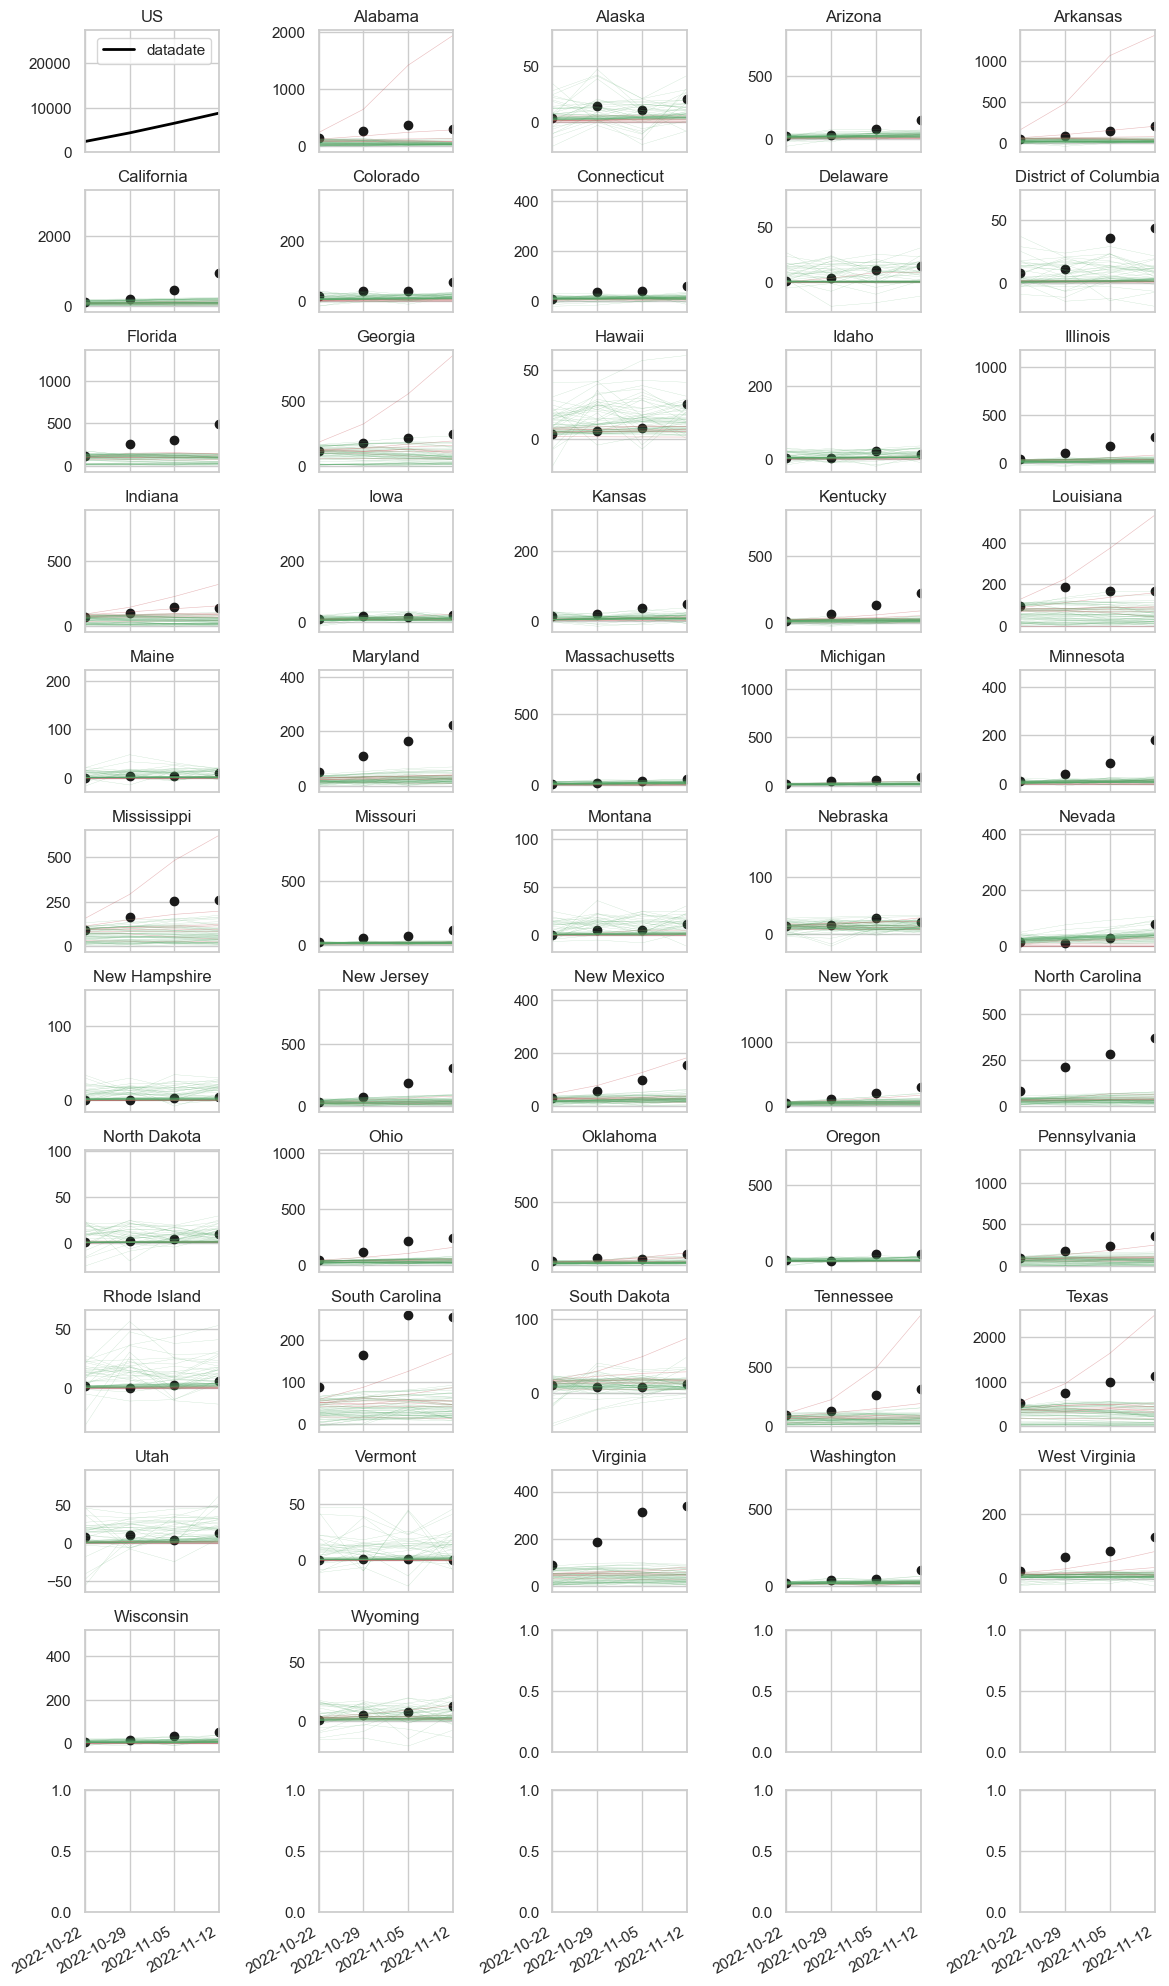

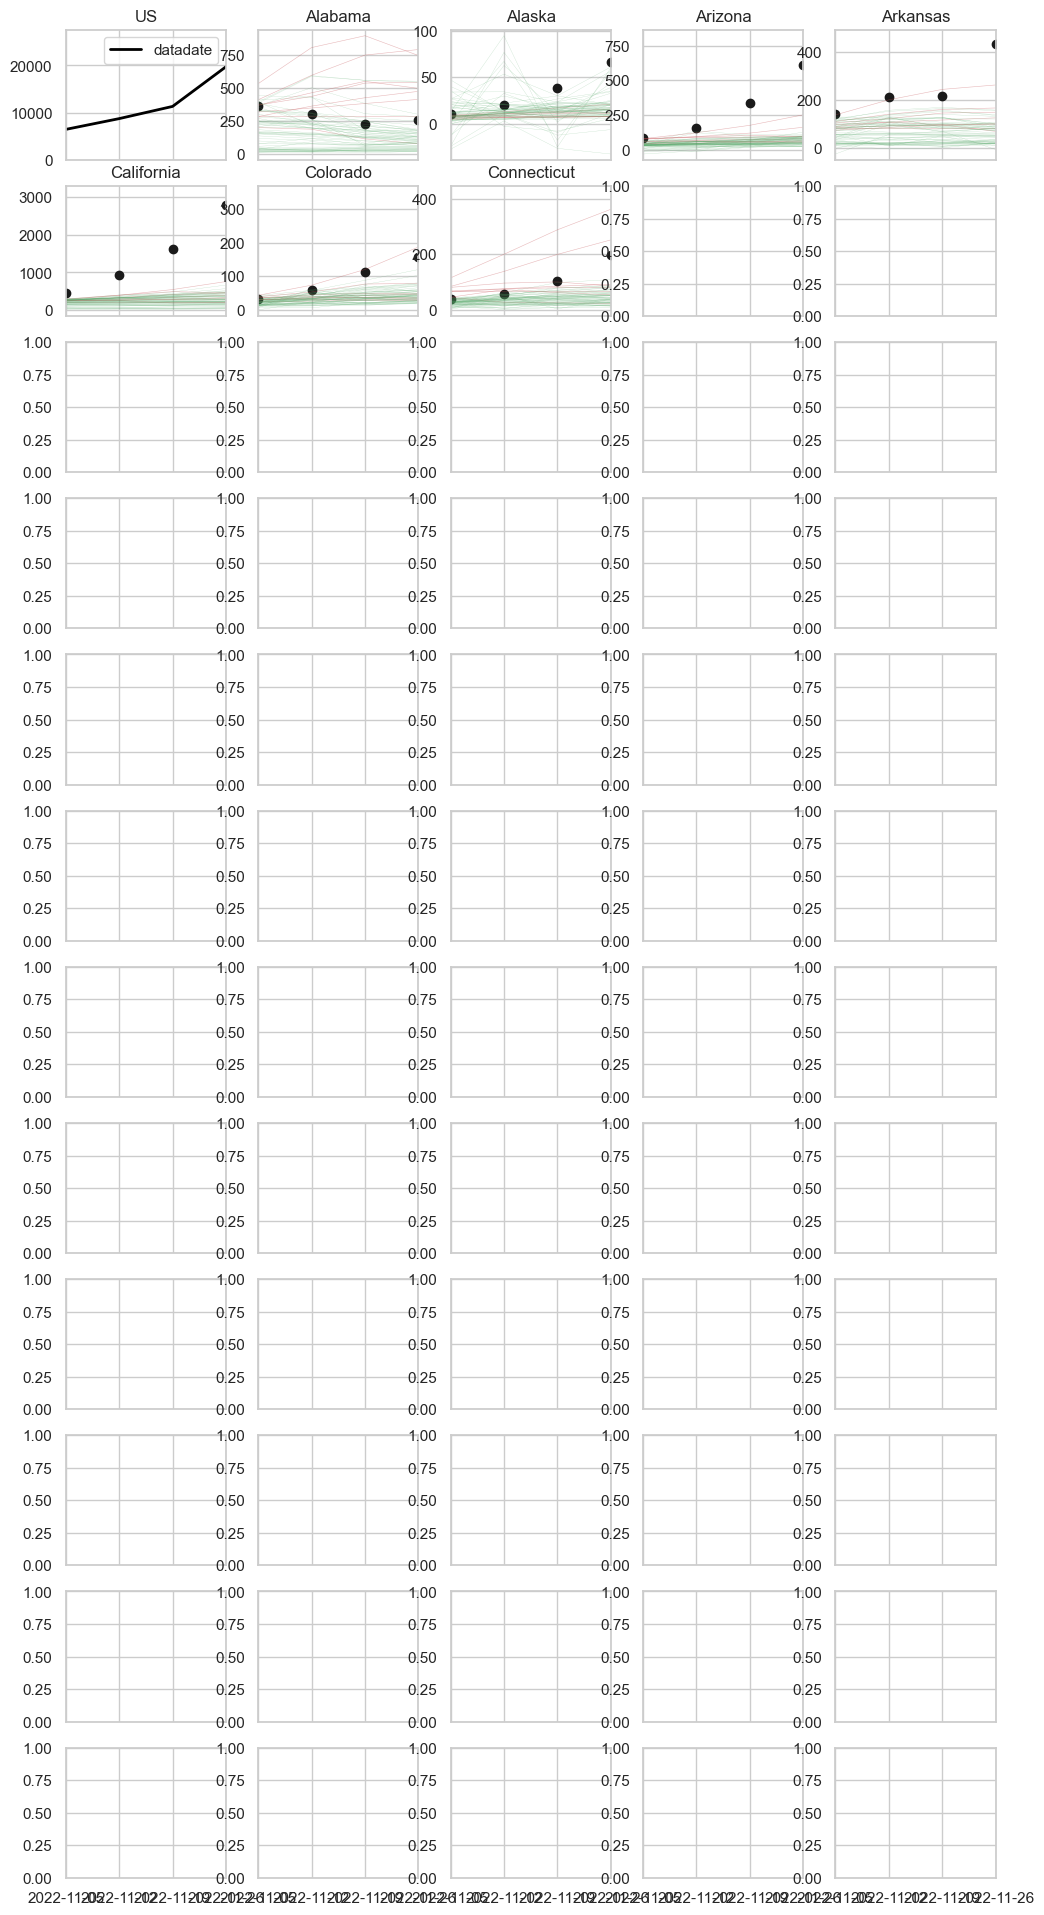

In [16]:
for idd, dt in enumerate(all_forecasts["forecast_date"].unique()):
    print(idd, dt)
    fig, axes = plt.subplots(12, 5, sharex=True, figsize=(12,24))
    gt_piv  = gt.pivot(index = "date", columns='location', values='value')
    gt_piv = gt_piv[gt1.flusetup.locations]

    ax = axes.flat[0]
    ax.plot(gt_piv[gt1.flusetup.locations].sum(axis=1), color="black", linewidth=2,label="datadate")
    ax.legend()
    ax.set_ylim(0)
    ax.set_title("US")
    for idx, pl in enumerate(gt_piv.columns):
        af_ot_piv = all_forecasts[(all_forecasts["forecast_date"]== dt) & 
                                (all_forecasts["quantile"]== .5) & 
                                (all_forecasts["location"]== pl) & 
                                (~all_forecasts["model"].str.contains('::'))].pivot(index="target_end_date", columns="model", values="value")
        af_my_piv = all_forecasts[(all_forecasts["forecast_date"]== dt) & 
                        (all_forecasts["quantile"]== .5) & 
                        (all_forecasts["location"]== pl) & 
                        (all_forecasts["model"].str.contains('::'))].pivot(index="target_end_date", columns="model", values="value")
        ax = axes.flat[idx+1]
        ax.plot(gt_piv[pl], lw=0, color='k', marker='o') 
        ax.plot(af_ot_piv, lw=.4, color='r', alpha=.4) 
        ax.plot(af_my_piv, lw=.2, color='g', alpha=.4) 
        ax.set_title(gt1.flusetup.get_location_name(pl))
        #ax.grid()
        #ax.set_ylim(0)
        #ax.set_xlim(gt1.flusetup.fluseason_startdate, gt1.flusetup.fluseason_startdate + datetime.timedelta(days=365))
        ax.set_xlim(af_ot_piv.index[0], af_ot_piv.index[-1])
        #ax.set_xticks(flusetup.get_dates(52).resample("M"))
        #ax.plot(pd.date_range(flusetup.fluseason_startdate, flusetup.fluseason_startdate + datetime.timedelta(days=64*7), freq="W-SAT"), data.flu_dyn[-50:,0,:,idx].T, c='r', lw=.5, alpha=.2)
    fig.tight_layout()
    fig.autofmt_xdate()

In [ ]:
print(fdates[0])
tp.head()

In [ ]:
print(fdates[0])
tp.head()

In [ ]:
print(fdates[0])
tp.head()

In [ ]:
a = wis_total[["wis_total","model"]].groupby("model").sum().sort_values(by="wis_total")
a

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.barh(a.index, a["wis_total"])


plt.tight_layout()
plt.show()


In [ ]:
a = wis_total[["wis_total","model"]].groupby("model").sum().sort_values(by="wis_total")
a

In [ ]:
all_scores

In [ ]:
tp = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [ ]:
tp = wis_total[wis_total["target"]=="1 wk ahead"].pivot(values="wis_total", index="location", columns="forecast_date")
tp = np.log(tp)
f, ax = plt.subplots(figsize=(9, 12))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [ ]:
# tp = wis_total.pivot(values="wis_total", index="location", columns=["forecast_date","target"])
# tp = np.log(tp)
# f, ax = plt.subplots(figsize=(12, 12), dpi=300)
# sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [ ]:
tp1 = wis_underprediction[wis_underprediction["location"]=="US"].pivot(values="wis_underprediction", index="target", columns="forecast_date")
tp2 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp1 = wis_sharpness[wis_sharpness["location"]=="US"].pivot(values="wis_sharpness", index="target", columns="forecast_date")
tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())

In [ ]:
tp1 = wis_underprediction[wis_underprediction["location"]=="US"].pivot(values="wis_underprediction", index="target", columns="forecast_date")
#tp2 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())

In [ ]:
tp1 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())